In [1]:
# Load required libraries
import torch
import tqdm
import copy
import numpy as np
# -custom-written libraries
import utils
from data.load import get_context_set
from models.classifier import Classifier
from models.vae import VAE
from eval import evaluate, callbacks as cb
from visual import visual_plt

In [2]:
# Enable plotting in the notebook
%matplotlib inline  

In [3]:
# Is cuda available?
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print("CUDA is {}used".format("" if cuda else "not "))

CUDA is used


## DATA: Prepare the data

In [4]:
# Specify what kind of continual learning experiment we should run
experiment = "splitMNIST"  #--> create context set by splitting up the MNIST dataset
contexts = 5               #--> split the dataset up into how many contexts?
iters = 1000               #--> number of iterations per context
batch = 128                #--> number of samples per iteration (i.e., the mini-batch size)

In [5]:
# Specify according to which scenario the continual learning experiment should be performed?
scenario = "class"

In [6]:
# Where is, or should, the data be stored?
d_dir = './store/datasets'

In [8]:
# Load the context set (both train- and test-data) for the specified continual learning experiment
(train_datasets, test_datasets), config = get_context_set(
    name=experiment, scenario=scenario, contexts=contexts, data_dir=d_dir, verbose=True, exception=True,
)

 --> MNIST: 'train'-dataset consisting of 60000 samples
 --> MNIST: 'test'-dataset consisting of 10000 samples


## CLASSIFIER: Specify the classifier network

In [9]:
# Specify the architectural layout of the network to use
fc_lay = 3        #--> number of fully-connected layers
fc_units = 400    #--> number of units in each hidden layer
fc_bn = False     #--> use batch-norm
fc_nl = "relu"    #--> what non-linearity to use?

In [10]:
# Define the model
model = Classifier(
    image_size=config['size'], image_channels=config['channels'], classes=config['output_units'],
    # -conv-layers are not used
    depth=0,
    # -fc-layers
    fc_layers=fc_lay, fc_units=fc_units, fc_bn=fc_bn, fc_nl=fc_nl, excit_buffer=True,
).to(device)

In [11]:
# Indicate to model what scenario it will be trained on and how many classes there are in each context
model.scenario = scenario
model.classes_per_context = config['classes_per_context']

In [12]:
# Indicate to the classifier model that it will be trained with generative replay
model.replay_mode = 'generative'
model.replay_targets = 'hard'

In [13]:
# Print layout of the model to the screen
utils.print_model_info(model)

-------------------------------------------------------
Classifier(
  (convE): ConvLayers(
    (pooling): Identity()
  )
  (flatten): Flatten()
  (fcE): MLP(
    (fcLayer1): fc_layer(
      (linear): LinearExcitability(in_features=784, out_features=400)
      (nl): ReLU()
    )
    (fcLayer2): fc_layer(
      (linear): LinearExcitability(in_features=400, out_features=400)
      (nl): ReLU()
    )
  )
  (classifier): fc_layer(
    (linear): LinearExcitability(in_features=400, out_features=10)
  )
)
-------------------------------------------------------
--> this network has 478410 parameters (~0.5 million)
       of which: - learnable: 478410 (~0.5 million)
                 - fixed: 0 (~0.0 million)


## GENERATOR: Specify the generative model

In [14]:
# Specify the architectural layout of the network to use
g_fc_lay = 3        #--> number of fully-connected layers
g_fc_units = 400    #--> number of units in each hidden layer
g_fc_bn = False     #--> use batch-norm
g_fc_nl = "relu"    #--> what non-linearity to use?
g_z_dim = 100       #--> number of units in latent space VAE

In [15]:
# Define the model
generator = VAE(
    image_size=config['size'], image_channels=config['channels'],
    # -conv-layers are not used
    depth=0,
    # -fc-layers
    fc_layers=g_fc_lay, fc_units=g_fc_units, fc_bn=g_fc_bn, fc_nl=g_fc_nl, excit_buffer=True,
    # -prior
    prior='standard', z_dim=g_z_dim,
    #-decoder
    recon_loss='BCE', network_output='sigmoid'
).to(device)

In [16]:
# Print layout of the generator to the screen
utils.print_model_info(generator)

-------------------------------------------------------
VAE(
  (convE): ConvLayers(
    (pooling): Identity()
  )
  (flatten): Flatten()
  (fcE): MLP(
    (fcLayer1): fc_layer(
      (linear): LinearExcitability(in_features=784, out_features=400)
      (nl): ReLU()
    )
    (fcLayer2): fc_layer(
      (linear): LinearExcitability(in_features=400, out_features=400)
      (nl): ReLU()
    )
  )
  (toZ): fc_layer_split(
    (mean): fc_layer(
      (linear): LinearExcitability(in_features=400, out_features=100)
    )
    (logvar): fc_layer(
      (linear): LinearExcitability(in_features=400, out_features=100)
    )
  )
  (fromZ): fc_layer(
    (linear): LinearExcitability(in_features=100, out_features=400)
    (nl): ReLU()
  )
  (fcD): MLP(
    (fcLayer1): fc_layer(
      (linear): LinearExcitability(in_features=400, out_features=400)
      (nl): ReLU()
    )
    (fcLayer2): fc_layer(
      (linear): LinearExcitability(in_features=400, out_features=784)
      (nl): Sigmoid()
    )
  )
  (

## PREPARE FOR TRAINING

In [17]:
# Settings for the optimizer to use
lr = 0.001           #--> learning rate to use

In [18]:
# For the classifier model, set up the optimizer to use
model.optim_list = [{'params': filter(lambda p: p.requires_grad, model.parameters()), 'lr': lr}]
model.optimizer = torch.optim.Adam(model.optim_list, betas=(0.9, 0.999))

In [19]:
# For the generative model, set up the optimizer to use
generator.optim_list = [{'params': filter(lambda p: p.requires_grad, generator.parameters()), 'lr': lr}]
generator.optimizer = torch.optim.Adam(generator.optim_list, betas=(0.9, 0.999))

In [20]:
# Prepare for keeping track of performance (on test set) during training, for later plotting
plotting_dict = evaluate.initiate_plotting_dict(contexts)

In [21]:
# Define callback function for keeping track of performance trhoughout training
eval_periodicity = 50
eval_cb = cb._eval_cb(log=eval_periodicity, test_datasets=test_datasets, plotting_dict=plotting_dict,
                      visdom=None, iters_per_context=iters, test_size=100)

In [22]:
# Set the models in training mode
_ = model.train()
_ = generator.train()

## TRAIN: Train the classifier and generative model on the continual learning experiment

In [23]:
# Indicate that on first context, there are no stored models yet for generating replay
previous_model = previous_generator = None
    
# Loop over all contexts.
for context, train_dataset in enumerate(train_datasets, 1):
    
    # Find [active_classes]
    if scenario=="task":
        # -for Task-IL scenario, create <list> with for all contexts so far a <list> with the active classes
        active_classes = [list(
            range(model.classes_per_context * i, model.classes_per_context * (i+1))
        ) for i in range(context)]
    else:
        # -for Domain- and Class-IL scenario, always all classes are active
        active_classes = None
    
    # Initialize # iters left on current data-loader(s)
    iters_left = 1
    
    # Define tqdm progress bar
    progress = tqdm.tqdm(range(1, iters+1))
    
    # Loop over all iterations
    for batch_index in range(1, iters+1):
        
        # Update # iters left on current data-loader(s) and, if needed, create new one(s)
        iters_left -= 1
        if iters_left==0:
            data_loader = iter(utils.get_data_loader(train_dataset, batch, cuda=cuda, drop_last=True))
            iters_left = len(data_loader)
            
        # -----------------Collect data------------------#

        #--> Sample training data of current context
        x, y = next(data_loader)
        # Adjust y-targets to 'active range'
        y = y-model.classes_per_context*(context-1) if scenario=='task' else y
        # Transfer them to correct device
        x, y = x.to(device), y.to(device)
        
        #--> Sample inputs to be replayed from stored copy of generative model
        if previous_model is not None:
            x_ = previous_generator.sample(batch, only_x=True)
            if not scenario=='task':
                with torch.no_grad():
                    scores_ = previous_model.classify(x_)
                _, y_ = torch.max(scores_, dim=1)
            else:
                # With Task-IL, [x_] needs to be evaluated according to each past context
                scores_ = list()
                y_ = list()
                with torch.no_grad():
                    all_scores_ = previous_model.classify(x_)
                for context_id in range(context-1):
                    temp_scores_ = all_scores_[:, active_classes[context_id]]
                    scores_.append(temp_scores_)
                    _, temp_y_ = torch.max(temp_scores_, dim=1)
                    y_.append(temp_y_)

            # Only keep predicted y/scores if required (as otherwise unnecessary computations will be done)
            y_ = y_ if (model.replay_targets == "hard") else None
            scores_ = scores_ if (model.replay_targets == "soft") else None
        else:
            x_ = y_ = scores_ = None    #-> when training on the first context, there is no replay yet
        
        # Train the classifier model on this batch
        loss_dict = model.train_a_batch(
            x, y, x_=x_, y_=y_, scores_=scores_, rnt = 1./context,
            active_classes=active_classes, context=context
        )
            
        # Train the generative model on this batch
        _ = generator.train_a_batch(x, x_=x_, rnt=1./context)
        
        # Update progress bar
        context_stm = " Context: {}/{} |".format(context, contexts)
        progress.set_description(
            '<CLASSIFIER> |{t_stm} training loss: {loss:.3} | training accuracy: {prec:.3} |'
                .format(t_stm=context_stm, loss=loss_dict['loss_total'], prec=loss_dict['accuracy'])
        )
        progress.update(1)
        
        # Execute callback-function to keep track of performance throughout training
        if eval_cb is not None:
            eval_cb(model, batch_index, context=context)
    
    ##----------> UPON FINISHING EACH CONTEXT...

    # Close progres-bar
    progress.close()
    
    # Update the source for the replay
    previous_generator = copy.deepcopy(generator).eval()
    previous_model = copy.deepcopy(model).eval()

<CLASSIFIER> | Context: 1/5 | training loss: 1.02e-06 | training accuracy: 1.0 |: 100%|████████████████████████████| 1000/1000 [00:28<00:00, 35.00it/s]
<CLASSIFIER> | Context: 2/5 | training loss: 0.00302 | training accuracy: 1.0 |: 100%|█████████████████████████████| 1000/1000 [00:35<00:00, 27.94it/s]
<CLASSIFIER> | Context: 3/5 | training loss: 0.0424 | training accuracy: 1.0 |: 100%|██████████████████████████████| 1000/1000 [00:36<00:00, 27.69it/s]
<CLASSIFIER> | Context: 4/5 | training loss: 0.0366 | training accuracy: 1.0 |: 100%|██████████████████████████████| 1000/1000 [00:36<00:00, 27.38it/s]
<CLASSIFIER> | Context: 5/5 | training loss: 0.14 | training accuracy: 0.977 |: 100%|██████████████████████████████| 1000/1000 [00:37<00:00, 26.70it/s]


## EVALUATION: average accuracy throughout training and samples from generator

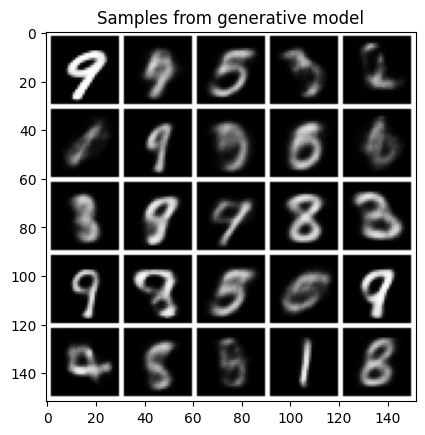

In [24]:
size = 25
sample = generator.sample(size)
image_tensor = sample.view(-1, config['channels'], config['size'], config['size']).cpu()
nrow = int(np.ceil(np.sqrt(size)))
visual_plt.plot_images_from_tensor(image_tensor, title='Samples from generative model', nrow=nrow)

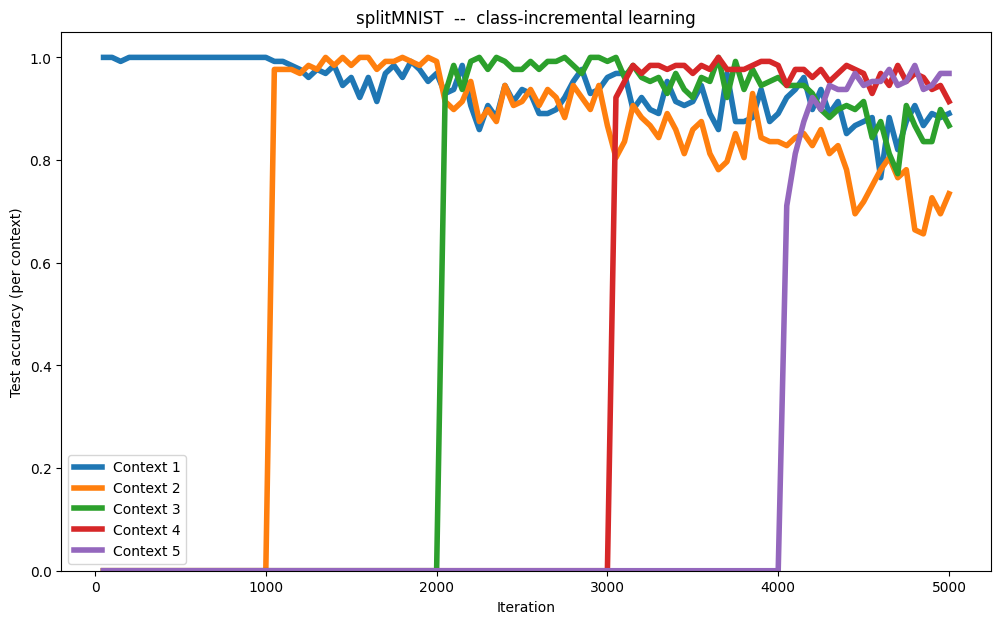

In [25]:
plot_list = []
for i in range(contexts):
    plot_list.append(plotting_dict["acc per context"]["context {}".format(i + 1)])
figure = visual_plt.plot_lines(
    plot_list, x_axes=plotting_dict["x_iteration"],
    line_names=['Context {}'.format(i + 1) for i in range(contexts)],
    ylabel="Test accuracy (per context)", ylim=(0,1.05) if scenario=="class" else None,
    xlabel="Iteration", title="{}  --  {}-incremental learning".format(experiment, scenario)
)